In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg as la

In [2]:
# Lattice vectors
a1 = np.array([1.0,0.0],dtype = complex)  # lattice vectors
a2 = np.array([0.0,1.0],dtype = complex)  

b1 = np.array([1.0,0.0],dtype = complex)  # reciprocal lattice vectors
b2 = np.array([0.0,1.0],dtype = complex)  

# special points in the MBZ
gpt = np.array([0.0,0.0], dtype = complex) # The Gamma point
xpt = np.array([0.5,0.0], dtype = complex) # The X point
ypt = np.array([0.0,0.5], dtype = complex) # The Y point
mpt = np.array([0.5,0.5], dtype = complex) # The M point

In [3]:
def distance(a,b): # finds the distance between two complex vectors (it ignores the imaginary part)
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [4]:
w=1.0 # w is the potential strength

In [5]:
Q_lattice = [] # create the Q lattice.  These are the origins of the multiple copies of the BZ
cutoff = 15
# create the Q lattice
for k in range(-50,50):
    for l in range(-50,50):
        q_pt = 2*k*np.pi*b1 + 2*l*np.pi*b2
        if distance(q_pt, gpt) < cutoff:
            Q_lattice.append(q_pt)

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


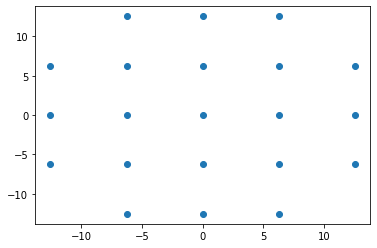

In [6]:
plt.scatter(np.array(Q_lattice)[:,0],np.array(Q_lattice)[:,1]) # the Q lattice

In [7]:
def generateHam(k): # create the Hamiltonian
    hamiltonian = np.zeros((len(Q_lattice),len(Q_lattice)),dtype=complex)
    for i, Qval in enumerate(Q_lattice):
        hamiltonian[i][i]+= 0.5*((k[0]-Qval[0])**2+(k[1]-Qval[1])**2)
        for j, Qval_prime in enumerate(Q_lattice):
            if distance(Qval-Qval_prime,2*np.pi*b1) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,-2*np.pi*b1) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,2*np.pi*b2) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,-2*np.pi*b2) < 0.001:
                hamiltonian[i][j] += w/2.
    return(hamiltonian)            

In [8]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
y_to_mx = [ypt * (1.0 - (t+0.0)/numpoints) + (-xpt) * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
mx_to_g = [(-xpt) * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
g_to_x = [gpt * (1.0 - (t+0.0)/numpoints) + xpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
x_to_m = [xpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)]
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = y_to_mx+mx_to_g+g_to_x+x_to_m+m_to_g # + means append here, so the list is 5*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [9]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(2*np.pi*k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [10]:
listOfValsForHistogram = []

for i in range(50):
    for j in range(50):
        ham = generateHam(2*np.pi*i/50.0*b1+2*np.pi*j/50.0*b2)
        eigval, eigvec = np.linalg.eigh(ham)
        listOfValsForHistogram.append(eigval[:5])

In [11]:
hist = np.array(listOfValsForHistogram).flatten()
a, b = np.histogram(hist, bins=200)
q = b[:200] + np.diff(b)/2.0
b[0]-np.diff(b)[0]/2.0
b[-1]+np.diff(b)[0]/2.0
np.diff(b)[3]*sum(a)

3055.971142804141

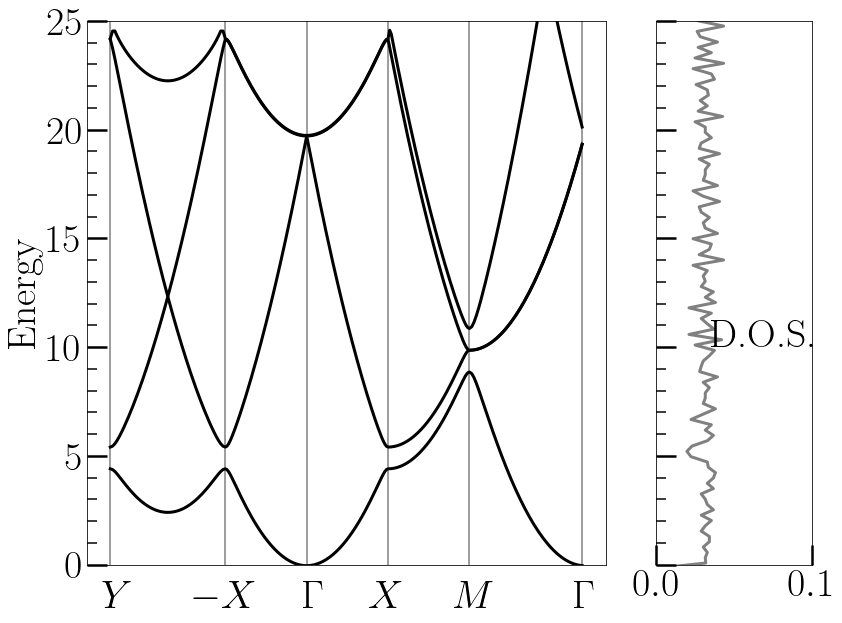

In [12]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10), gridspec_kw={'width_ratios': [1,0.3]})
plt.subplots_adjust(wspace=0.15)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=20)

axes[0].axes.get_xaxis().set_visible(False)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0], color='gray')
axes[0].text(len_k[0]-.05,-2,r'$Y$',rotation=0)
axes[0].axvline(x=len_k[50], color='gray')
axes[0].text(len_k[50]-.2,-2,r'$-X$',rotation=0)
axes[0].axvline(x=len_k[100], color='gray')
axes[0].text(len_k[100]-.025,-2,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[150], color='gray')
axes[0].text(len_k[150]-.125,-2,r'$X$',rotation=0)
axes[0].axvline(x=len_k[200], color='gray')
axes[0].text(len_k[200]-.1,-2,r'$M$',rotation=0)
axes[0].axvline(x=len_k[249], color='gray')
axes[0].text(len_k[249]-.05,-2,r"$\Gamma$",rotation=0)
axes[0].set_ylim([0, 25])
axes[0].set_ylabel('Energy')

for i in range(0,4):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')

axes[0].get_yaxis().set_major_locator(MultipleLocator(5))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)
    
axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))

ap = np.concatenate(([0],a,[0]))
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[1].plot(ap/3056, qp, linewidth=3, color='gray')
axes[1].get_yaxis().set_major_locator(MultipleLocator(5))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 0.1])
axes[1].set_ylim([0, 25])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.035,10,r"D.O.S.",rotation=0)

plt.savefig('SquareNoFluxLowW.png',bbox_inches='tight')

In [13]:
w=7.0

In [14]:
def generateHam(k):
    hamiltonian = np.zeros((len(Q_lattice),len(Q_lattice)),dtype=complex)
    for i, Qval in enumerate(Q_lattice):
        hamiltonian[i][i]+= 0.5*((k[0]-Qval[0])**2+(k[1]-Qval[1])**2)
        for j, Qval_prime in enumerate(Q_lattice):
            if distance(Qval-Qval_prime,2*np.pi*b1) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,-2*np.pi*b1) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,2*np.pi*b2) < 0.001:
                hamiltonian[i][j] += w/2.
            if distance(Qval-Qval_prime,-2*np.pi*b2) < 0.001:
                hamiltonian[i][j] += w/2.
    return(hamiltonian)            

In [15]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
y_to_mx = [ypt * (1.0 - (t+0.0)/numpoints) + (-xpt) * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
mx_to_g = [(-xpt) * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
g_to_x = [gpt * (1.0 - (t+0.0)/numpoints) + xpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
x_to_m = [xpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)]
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = y_to_mx+mx_to_g+g_to_x+x_to_m+m_to_g # + means append here, so the list is 5*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [16]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(2*np.pi*k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [17]:
listOfValsForHistogram = []

for i in range(50):
    for j in range(50):
        ham = generateHam(2*np.pi*i/50.0*b1+2*np.pi*j/50.0*b2)
        eigval, eigvec = np.linalg.eigh(ham)
        listOfValsForHistogram.append(eigval[:5])

In [18]:
hist = np.array(listOfValsForHistogram).flatten()
a, b = np.histogram(hist, bins=200)
q = b[:200] + np.diff(b)/2.0
b[0]-np.diff(b)[0]/2.0
b[-1]+np.diff(b)[0]/2.0
area = np.diff(b)[3]*sum(a)

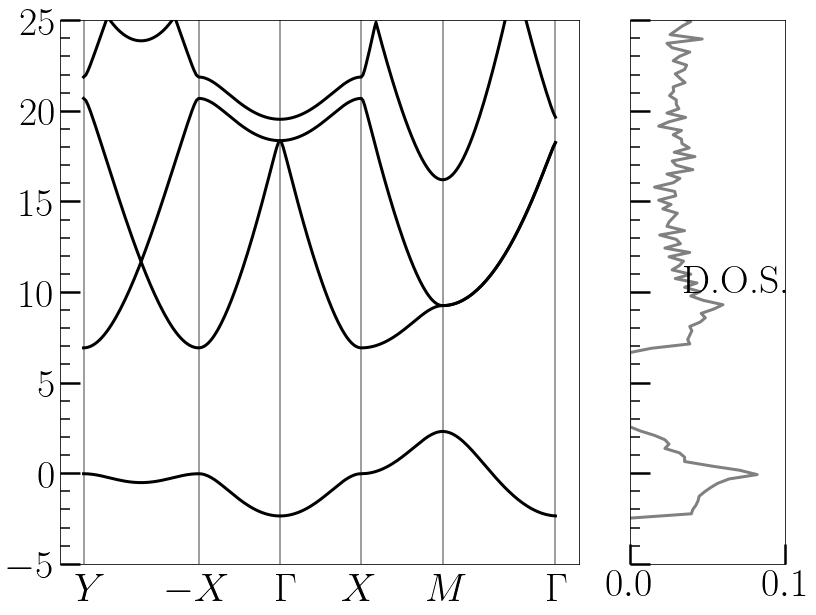

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10), gridspec_kw={'width_ratios': [1,0.3]})
plt.subplots_adjust(wspace=0.15)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=20)

axes[0].axes.get_xaxis().set_visible(False)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0], color='gray')
axes[0].text(len_k[0]-.05,-2-5,r'$Y$',rotation=0)
axes[0].axvline(x=len_k[50], color='gray')
axes[0].text(len_k[50]-.2,-2-5,r'$-X$',rotation=0)
axes[0].axvline(x=len_k[100], color='gray')
axes[0].text(len_k[100]-.025,-2-5,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[150], color='gray')
axes[0].text(len_k[150]-.125,-2-5,r'$X$',rotation=0)
axes[0].axvline(x=len_k[200], color='gray')
axes[0].text(len_k[200]-.1,-2-5,r'$M$',rotation=0)
axes[0].axvline(x=len_k[249], color='gray')
axes[0].text(len_k[249]-.05,-2-5,r"$\Gamma$",rotation=0)
axes[0].set_ylim([-5, 25])
#axes[0].set_ylabel('Energy')

for i in range(0,4):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')

axes[0].get_yaxis().set_major_locator(MultipleLocator(5))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)
    
axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))

ap = np.concatenate(([0],a,[0]))
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[1].plot(ap/area, qp, linewidth=3, color='gray')
axes[1].get_yaxis().set_major_locator(MultipleLocator(5))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 0.1])
axes[1].set_ylim([-5, 25])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.035,10,r"D.O.S.",rotation=0)

plt.savefig('SquareNoFluxHighW.png',bbox_inches='tight')